According to Matt's epxeriance ([link](https://github.com/goodarzilab/khorms/blob/master/side_projects/COVID_DMSseq_library.ipynb)) I'm using this genome:

- https://www.ncbi.nlm.nih.gov/nuccore/MN908947?%3Fdb=nucleotide


# Peaks
<img src="plots/igv_snapshot.png" style="height:400px">

# _N_
<img src="plots/N1.png" style="height:400px">
<img src="plots/N2.png" style="height:400px">
<img src="plots/N3.png" style="height:400px">

# _ORF10_
<img src="plots/orf10.png" style="height:400px">

# _S_
<img src="plots/S1.png" style="height:400px">
<img src="plots/S2.png" style="height:400px">


In [287]:
import re
import pandas as pd 

DRACH = re.compile('[AGT][AG]AC[ACT]') 
RGAC = re.compile('[AG]GAC') 
AAGAA = re.compile('AAGAA') 

def read_fasta(path):
    file = open(path)
    lines = file.read().splitlines()
    ids = [s[1:] for s in lines if '>' in s]
    n = [i for i,s in enumerate(lines) if '>' in s]
    n.append(len(lines))
    sequences = [''.join(lines[i+1:j]) for i,j in zip(n[:-1],n[1:])]
    file.close()
    fa = dict(zip(ids, sequences))
    return fa

def find_motifs(sam):
    motifs = [[f.split('::')[0], 
         len(DRACH.findall(sam[f])), 
         len(RGAC.findall(sam[f])), 
         len(AAGAA.findall(sam[f])),
         ','.join(DRACH.findall(sam[f]) + RGAC.findall(sam[f]) + AAGAA.findall(sam[f]))
             ]
        for n, f in enumerate(sam)
              
    ]
    
    df = pd.DataFrame(motifs, columns=["loci","DRACH", "RGAC", "AAGAA","Sequence"])
    
    return df


peaks = read_fasta('lowCt_peaks.fa')

df = find_motifs(peaks)
df.replace("", nan_value, inplace=True)

df.dropna(subset=["Sequence"])

,loci,DRACH,RGAC,AAGAA,Sequence
1,S,6,1,0,"GAACC,AGACT,TGACC,AAACA,AAACT,TAACT,AGAC"
7,S,2,2,0,"AGACT,AGACT,AGAC,AGAC"
9,N,1,1,0,"GGACC,GGAC"
10,N,2,0,0,"TAACC,AAACA"
12,N,3,2,0,"AGACC,GGACA,TAACA,AGAC,GGAC"
13,N,0,1,0,AGAC
14,N,1,0,0,GAACT
16,N,1,0,0,TAACA
18,N,1,0,0,GAACT
19,N,2,1,0,"AAACC,GGACC,GGAC"


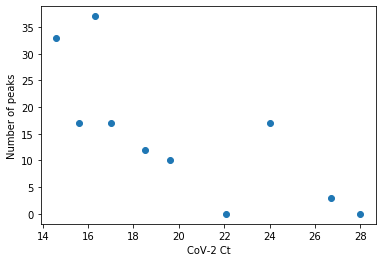

In [177]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

qPCR = pd.read_csv('RTqPCR.txt', sep='\t',index_col=0)
# create some x data and some integers for the y axis
x = np.array(qPCR.iloc[:,0])
y = np.array(qPCR.iloc[:,1], dtype=int)

# plot the data
# fig = plt.figure()
# plt.scatter(x, y)
# plt.xlabel('CoV-2 Ct', fontsize=10)
# plt.ylabel('Number of peaks', fontsize=10)
# fig.savefig('plots/Ct_vs_peak.pdf')
plt.scatter(x, y)
plt.xlabel('CoV-2 Ct', fontsize=10)
plt.ylabel('Number of peaks', fontsize=10)
plt.show()

## internal control 
m6A+ m6A- [N6-Methyladenosine Enrichment Kit](https://international.neb.com/-/media/nebus/files/manuals/manuale1610.pdf?rev=c064d5e232414f709ef8bccee56f7687&hash=AAA94B8FDA043DD5A610E14686552B5E0209EA94)

In [364]:
qPCR = pd.read_csv('RTqPCR.txt', sep='\t',index_col=0)

res = pd.read_csv('internal_control/result.txt', sep='\t')

pos  = [np.log2(res.loc[i+1,'pos']/res.loc[i,'pos']) for i in list(range(0,res.shape[0],2))]
neg  = [np.log2(res.loc[i+1,'neg']/res.loc[i,'neg']) for i in list(range(0,res.shape[0],2))]

Samples = [res.iloc[i,0].split('_')[0] for i in list(range(0,res.shape[0],2))]

log2res = pd.DataFrame(index=Samples)

qPCR['m6A_pos_ctrl'] = pos
qPCR['m6A_neg_ctrl'] = neg

qPCR


,CoV-2 Ct,Number of peaks,m6A_pos_ctrl,m6A_neg_ctrl
Sample,,,,
S0008,19.6,10,3.683781,-2.090802
S0009,18.5,12,6.804162,-0.219748
S0014,16.3,37,2.141356,-3.560361
S0017,24.0,17,1.651047,-7.253435
S0025,22.1,0,6.203816,-1.010379
S0026,15.6,17,8.585372,2.581687
S0030,17.0,17,8.069236,1.410737
S0042,28.0,0,4.671282,-0.919416
S0057,26.7,3,8.344047,-1.969256


200429_NS500257_0111_AH2V3CBGXF/  fastqI/            plots/      virus/
bam/                              internal_control/  qc_star/    virus_bam/
cell_paper/                       lowCt_peaks.bed    RTqPCR.txt  virus_count/
demultiplex_index.txt             lowCt_peaks.c.bed  rumi/       virus_fastq/
exomepeak/                        lowCt_peaks.fa     _sh/        virus.zip
fastq/                            notebook.ipynb     trim/


In [422]:
import os
import pandas as pd

#list the files
filelist = os.listdir('virus_count')

#read them into pandas
df_list = [pd.read_csv('virus_count/' + file, header=None, sep='\t', index_col=0) for file in filelist]
#concatenate them together
big_df = pd.concat(df_list, axis=1)
big_df.columns = [f.split('.')[0] for f in filelist]

Peak_names = big_df.index.tolist()
Samples = np.unique([f.split('_')[0] for f in filelist]).tolist()

res = list()
for s in Samples:
    data = big_df.filter(like=s)
    res.append([s, np.log2 (np.array(data.filter(like='RIP'), dtype=int) / np.array(data.filter(like='IN'), dtype=int) )])
    

res_df = pd.DataFrame(data=np.concatenate([r[1] for r in res], axis=1), 
             columns=[r[0] for r in res],
             index=Peak_names)
res_df.to_csv('log2RIPvsIN.txt')
res_df

,S0008,S0009,S0014,S0017,S0025,S0026,S0030,S0042,S0057,S0085
N_peak,-1.419539,3.094327,-5.804827,-1.772947,2.837167,3.443329,3.418020,2.783654,0.171242,2.433774
N_peak_10,-0.850783,4.094327,-5.197406,-1.772098,2.935536,2.589521,1.674362,2.786430,0.165586,1.135859
N_peak_11,-2.074677,4.657112,-3.714559,-1.777989,2.869887,3.204982,1.099996,2.809540,0.161692,1.556074
N_peak_12,-1.448000,4.036723,-1.126578,-1.793937,2.918386,3.147463,2.667740,2.836804,0.153936,2.528701
N_peak_13,-2.492014,3.499571,-2.246635,-1.794465,2.754888,3.156091,2.930574,2.838393,0.150073,2.597607
N_peak_14,-2.176355,4.270089,0.599944,-1.803421,2.861803,3.304903,1.235407,2.838393,0.150073,1.546360
N_peak_15,-0.905478,3.881819,-6.441363,-1.797105,2.872943,2.004188,1.919031,2.838393,0.153936,1.407446
N_peak_16,-2.490233,3.783606,-5.275955,-1.819611,2.757938,1.941162,2.566483,2.827078,0.138547,1.812151
N_peak_2,-1.673872,2.795986,-2.128884,-1.772947,2.793446,3.933286,3.410968,2.775465,0.167295,2.376512
N_peak_3,-2.568117,2.921217,-0.797945,-1.765427,2.870850,4.309560,2.948174,2.779276,0.177331,2.717156


In [418]:
cat _sh/pipeline.sh

###################### pre processing #############################
conda activate deseq 

mkdir -p trim
for fq in fastq/S00*R2*; do
    fq=`basename $fq`;
    out=${fq/_001.fastq.gz/.trim.fastq.gz};
    echo -------------------------$fq------------------------
    cutadapt -j 12 -u 3 -o trim/$out fastq/$fq
done

# map to human genome 
mkdir -p bam

STAR --genomeLoad LoadAndExit --genomeDir /rumi/shams/genomes/hg38/

for fq in fastq/*_R1*; do
    fq1=`basename $fq`;
    fq2=${fq1/R1_001.fastq.gz/R2.trim.fastq.gz};
    out=${fq1/R1_001.fastq.gz/};
    STAR \
    --outSAMtype BAM SortedByCoordinate \
    --readFilesCommand zcat \
    --runThreadN 16 \
    --genomeDir /rumi/shams/genomes/hg38/ \
    --readFilesIn fastq/$fq1 trim/$fq2 \
    --outFileNamePrefix bam/$out \
    --outReadsUnmapped Fastx;
done

STAR --genomeLoad Remove --genomeDir /rumi/shams/genomes/hg38/
rm Aligned.out.sam Log*out
rm -r bam/Undetermined_S0*

mkdir -p virus_fastq
mv bam/*_Unmapped.out.mate[1-2] virus_fastq/

m